In [3]:
#libraries and data import - needed for later code, will figure out to try and hide this later
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

data_dir = "/Users/jonathanzhu/Documents/data/"

text_file_name = "osdg-community-data-v2023-01-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
col_names = text_df.columns.values[0].split('\t')
text_df[col_names] = text_df[text_df.columns.values[0]].apply(lambda x: pd.Series(str(x).split("\t")))
text_df = text_df.astype({'sdg':int, 'labels_negative': int, 'labels_positive':int, 'agreement': float}, copy=True)

In [5]:
#preprocessing - will hide later
from googletrans import Translator
from langdetect import detect
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2")
text_df.reset_index(inplace=True, drop=True)
text_df["lang"] = text_df["text"].apply(lambda x: detect(x))

<h1>2. About Text Data</h1>

<h2>2.1 Transformation</h2>

ML algorithms of any kind expect numerical features with fixed dimensions. This is especially the case for supervised learning algorithms such as classification algorithms, which is what we will be using to classify our texts into the UN SDG categories.

In a documents, raw text data is semi-structured with uneven length and varied contents. As such, text data is semi-structured, with uneven length and varied contents. This poses a problem for ML methods as they typically operate on numerical vectors of equal length. 

Therefore, once we have our preprocessed text data, our next job is to transform it, and the main way we do this is to <i>vectorize</i>, or transform a body of text into numerical vectors. When we map documents into vectors, we can use several techniques, which we will discuss later: 
<ul>
<li>bag of words</li>
<li>n-grams</li>
<li>word embedding</li>
</ul>

Vectorization, and transformation of textual data as a whole, depends on tokenization, and carefully chosen preprocessing steps could help reduce complexity and increase ML model accuracy. 


<h3>2.1.1 Vectorizations</h3>

<h4>Bag of Words</h4>

The <b>bag of words</b> approach treats a text or document almost literally as a bag of words; i.e., it ignores the order of the words and simply collects all the words together in one big set. All the words are then treated as features, with one feature for each word. We then set a fixed number of words to be considered, and our bag of words becomes the vocabulary we work with. 

Let's analyze the vocabulary of our UN SDG dataset. We use $\texttt{CountVectorizer()}$ to create our bag of words, then look at the length of our vocabulary:

In [6]:
docs = text_df.text
count_vectorizer = CountVectorizer()
count_vectorizer.fit(docs) 
len(count_vectorizer.vocabulary_)

45738

<b>Exericse 2.1</b>: Use $\texttt{count\_vectorizer.vocabulary\_}$ to get the amount of each word in our vocabulary. What words are the most common?

Note that the stop words are not removed by default, so we will get a lot of generic words like "the". Fortunately, we can easily modify our code to remove stop words:

In [7]:
docs = text_df.text
count_vectorizer = CountVectorizer(ngram_range=(1,1),stop_words='english') 
count_vectorizer.fit(docs) 

CountVectorizer(stop_words='english')

$\texttt{CountVectorizer()}$ also has an easy way to retrieve the stop words, so we can easily see which words we are removing:

In [8]:
print(count_vectorizer.get_stop_words())

frozenset({'some', 'ten', 'find', 'thus', 'her', 'our', 'whither', 'sincere', 'seeming', 'con', 'seems', 'whole', 'if', 'thru', 'else', 'fifty', 'was', 'though', 'get', 'take', 'not', 'will', 'twelve', 'him', 'first', 'move', 'am', 'when', 'against', 'next', 'hereby', 'throughout', 'of', 'this', 'but', 'moreover', 'others', 'last', 'because', 'hasnt', 'per', 'everything', 'former', 'up', 'since', 'whence', 'whatever', 'latter', 'amount', 'bottom', 'whether', 'indeed', 'sometime', 'bill', 'again', 'within', 'latterly', 'wherein', 'alone', 'interest', 'herein', 'nine', 'he', 'mill', 'front', 'a', 'and', 'none', 'serious', 'thereupon', 'several', 'therein', 'behind', 'twenty', 'often', 'before', 'nothing', 'amoungst', 'somewhere', 'side', 'whereas', 'yourselves', 'during', 'third', 'between', 'mine', 'any', 'were', 'becoming', 'cry', 'still', 'myself', 'name', 'only', 'see', 'another', 'itself', 'nor', 'you', 'along', 'detail', 'whoever', 'these', 'back', 'there', 'whenever', 'system', 'e

<b>Exercise 2.2</b>: Find the length of the vocabulary without stop words, and also find the length of the list of stop words. Is the difference between our original vocabulary and our stop word removed vocabulary equal to the number of stop words? If not, why not?

<h4>One-Hot Vectors</h4>

Another vectorization approach is to treat a text as a <b>one-hot vector</b>. This approach lines up all words in the vocabulary and labels them $1, …, V$. It then forms a vector 

$\overrightarrow{w} = (0, 0, …, 0, 1, 0, 0, …, 0)$ , 

with only one 1 in the vector and the rest of the numbers being zeroes. The 1 is at the position that indexes the word in our vocabulary, and the order of occurrence is ignored, so it does not matter if a certain word is indexed before another one. Because all of the words in our vocabulary are unique, there are no similarity notions among the vectors. 

<h4>Numeric Count Vectors</h4>

A third vectorization approach is to make a numeric vector of counts. This approach counts the occurence of the words in the document and lines up the counts of words in a row for each document. 

<h4>Term-Document Matrices</h4>

One final vectorization approach we will introduce here is to form a document-term matrix. To form this matrix, we define the matrix's columns to be tokens (such as terms or phrases), the matrix's rows to be the documents in the collection, and the value of each entry to be frequency of each token occuring in the document. Additionally, the values in each entry are weighted frequencies; one weighting method we use is TF-IDF, or term frequency (TF) times inverse document frequency (IDF). TF refers to the frequency of the word in the document, while IDF refers to the inverse of the number of documents containing the word divided by number of documents. TF-IDF is discussed later in this section.

The below figure provides a simple term-document matrix in unigram (one-word token) form. While the unigram does provide context for each word, NLP tasks built on such simple model would be disadvantaged. 

In [9]:
docs = text_df.text
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer.fit(docs)
count_vector = count_vectorizer.transform(docs).toarray() 
count_vector_df = pd.DataFrame(count_vector, columns=count_vectorizer.get_feature_names_out())
term_freq = pd.DataFrame({"term": count_vector_df.columns.values, "freq" : count_vector_df.sum(axis=0)})
count_vector_df.loc[100:125,term_freq.sort_values(by="freq", ascending =False)[:20].term] # take a portion

,countries,women,development,health,water,public,social,education,policy,international,law,energy,national,rights,oecd,economic,use,new,level,income
100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
101,1,0,0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0,1,0
102,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0
103,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
104,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
105,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
106,1,3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,2
107,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
108,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
109,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0


<b>Exercise 2.3</b>: Look at document 118. 
<ol>
<li>What are the most frequent words for this document?</li>
<li>Refer to the UN SDGs. What is your best guess as to which goal this document describes?</b>
</ol>

<h3>2.1.2 N-Grams</h3>

An n-gram is a contiguous sequence of $n$ items from a text. Items in an n-gram are tokens we choose to include through preprocessing, but these items can also include markers we add to the data to serve the NLP tasks at hand. 

For example, if we were to find what words are often used at the beginning or end of a sentence, we would add &lt;s&gt; and &lt;/s&gt; as markers for the beginnings and ends of sentences, to denote the sentence boundaries. We would then build bigrams $(n=2)$; for the sentence "I built an AI machine”, we would get the items 
(&lt;s&gt; I), (I built), (built an), (an AI), (AI machine), and (machine &lt;/s&gt;). We then count the frequency of bigrams. specifically of the form (&lt;s&gt; \*) and (\* &lt;/s&gt;), where \* represents any other token.

In the previous subsection, we looked at a term-document matrix of unigrams. We can check the total number of unigrams with the following:


In [10]:
term_freq.freq.sum()

1351051

We then compare this to the total frequency of terms (without stop word removal) of our entire document corpus:

In [11]:
docs.apply(lambda x: len(x.split())).sum()

2351777

Notice that stop word removal alone reduced the number of terms by around 40%. Next, we can check the bi-grams for our document corpus:

In [12]:
docs = text_df.text
count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english') 
count_vectorizer.fit(docs) 
len(count_vectorizer.vocabulary_)

834465

<b>Exercise 2.4</b>: Notice that with stop word removal and bi-gram formation, we get fewer terms. Why might this be the case?

<b>Exercise 2.5</b>: Modify the above code to get the counts of the tri-grams. Are there more or fewer tri-grams than bi-grams? Why might this be the case?

<h3>2.1.3 Probabilistic Language Modeling</h3>

So far, we have worked with clearly defined texts and sequences of words. But sometimes, the texts we get are incomplete, or we might want to reduce computational time by only giving portions of the text. As such, we might turn to probabilistic language modeling. Typically, a probabilistic language model analyzes a body of text data and computes the following based on that body of text data: 

 - the probability of a sentence or sequence of words occurring, $P(w_1, w_2, w_3, … , w_n)$,
 - the probability of the next word given $k$ words, $P(w_n | w_{(n-k)}, w_{(n-(k-1))}, … , w_{(n-1)})$.


We then use the chain rule to compute the joint probability: 

$P(A \cap B) = P(B|A)*P(A)$ 

$\implies P(w_1, w_2, w_3, …, w_n) = 
P(w_1)P(w_2|w_1)P(w_3|w_1,w_2)...P(w_n|w_1, …, w_{(n-1)})$.


We could estimate the probability by calculating

$\text{count}(w_1, w_2, …, w_{(i-1)}, w_i) / \text{count}(w_1, w_2, …, w_{(i-1)})$,

but with too many possible occurrences, this calculation is not feasible.

Instead, we can simplify the equation through the Markov Assumption, placing condition on previous $k$ words rather than all the previous words:

$P(w_n|w_1, w_2, w_3, …, w_{(n-1)}) \sim  P(w_n|w_{(n-k)}, …, w_{(n-1)})$.

When considering a unigram $(n=1)$ model, we calculate the probability as

$P(w_1, w_2, w_3, …, w_n) = P(w_1)P(w_2)P(w_3)...P(w_n)$.

A similar process occurs when considering a bigram $(n=2)$ model, where we place a condition on the previous word,

$P(w_n|w_1, …, w_{(n-1)}) \sim P(w_i|w_{(i-1)})$,

and we can similarly extend this process to trigrams, 4-grams, 5-grams, or any n-gram.

However, no matter how many $n$ we consider, we still will not arrive at a sufficient model; language has long-distance dependencies that require extremely large $n$ that can even extend to previous sentences and/or documents. To truly determine if our n-gram is sufficient, we extrinsically evaluate it by putting our model to tasks. For example, if we only want to deal with spell correction, a unigram be sufficient, but for machine translation, we might need to work with very long sentences. Google’s recent speech model features 20B sentences (https://arxiv.org/abs/2303.01037?utm_source=substack&utm_medium=email). 




<h3>2.1.4 Natural Language Generation</h3>

Natural Language Generation (NLG) is a similar offshoot of Probabilistic Language Modeling, with it mainly being used to complete sentences, giving the next few words based on a short incomplete sentence.

<b>Exercise 2.6:</b> Use the Allen NLP Language Modeling demo: https://demo.allennlp.org/next-token-lm to try and predict the next word for incomplete sentences.
<ol>
<li>Try “The Israel Oceanographic and Limnological Research station monitors the quantity and quality of ”. What was the most likely predicted completion?</li>
</ol>

The real sentence from Exercise 1 is: 'The Israel Oceanographic and Limnological Research station monitors the quantity and quality of water along the coastline of the Mediterranean Sea.’ So these language models are not perfect, but especially with recent developments in AI, they are improving. 

The main role of NLG is automatic summarization of a text. The NLG has the ability to perform extractive summarization (extracting meaning from a text), or abstractive summarization (constructing an abstract from a text). The NLG can also be used for topic modeling to identify the main topics of the text, or as an advanced machine translation tool.

An even more advanced natural language generator is the Generative Pre-trained Transformer (GPT), mainly pioneered by the startup OpenAI. The GPT is a text generation deep learning model trained on massive datasets, including internet data, book data, Github data, and more. GPTs, including the famous ChatGPT, can take thousands of words as input and have been trained on billions of different parameters.



<h2>2.2 Features</h2>

<h3>2.2.1 TF-IDF (Term Frequency, Inverse Document Frequency)</h3>

In the document-term matrix previously discussed, we represented columns as tokens, rows as documents, and the entry values as the number of occurrences of that token in the document. In our computation of the matrix cell $(d,t)$ with document as row and term as column, we compute the following:

 - TF: term frequency of term $t$ in the document $d$ = 
count of term $t$ in document $d$ divided by total number of terms in document $d$
 - DF: document frequency of term $t$ = 
number of documents containing term $t$ divided by total number of documents
$\frac{\text{df}}{N}$, where $N$ is the total number of documents and is a constant that can be ignored
 - IDF: take the inverse of DF
 - TF-IDF = TF * IDF

We can use $\texttt{scikit-learn}$ to get TF-IDF with $\texttt{scikit-learn.feature\_extraction.text.TfidfVectorizer}$. This code takes several arguments:

 - $\texttt{sublinear\_df}$ : Boolean; if true, uses a logarithmic form for frequency,
 - $\texttt{min\_df}$ : the minimum number of documents a word must be present in to be kept,
 - $\texttt{norm}$: usually set to l2 to ensure all our feature vectors have a Euclidean norm of 1,
 - $\texttt{ngram\_range}$: takes one of (1, 2) to consider both unigrams and bigrams, and
 - $\texttt{stop\_words}$:  usually set to "english" for removing  English stop words.

Note that when using logarithmic form for term frequency, the weighted TF is transformed into $1 + \log \text{TF}$; if $\text{TF} > 0$, then $\text{TF} = 0$; otherwise, we use $\log\frac{N}{\text{df}}$ for IDF to dampen the effect of $\frac{N}{\text{df}}$.

<h3>2.2.2 Feature Effectiveness</h3>

In examining how to evaluate the effectiveness of features in the context of NLP tasks, we will mainly use the task of document classification and classifying our texts into SDG categories as mentioned in the preface of this section.

When looking at document classification, we can use a confusion matrix and get $tp, fn, fp, tn$; these can be used to calculate the precision, recall, and f1 measures as follows:

 - precision: $\frac{tp}{tp+fp}$,
 - recall: $\frac{tp}{tp+fn}$,
 - f1: $2 * \frac{\text{precision } * \text{ recall}}{\text{precision } + \text{ recall}}$.

Below, we use a mulitnomial Naive Bayes algorithm to classify our documents by their SDG; the process of this is explained in later sections. For now, we examine the multiclass confusion matrix classifying documents by their respective UN SDG:

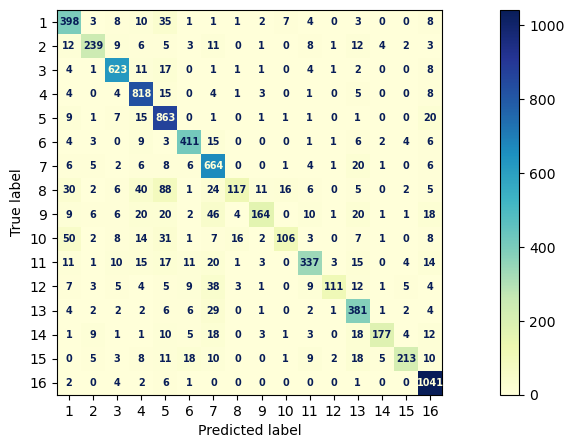

In [14]:
docs = text_df.text
categories = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(docs, categories, test_size=0.33, random_state=7)

X_train_count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words = "english" )
X_train_count_vectorizer.fit(X_train) 
X_train_count_vector = X_train_count_vectorizer.transform(X_train) 
X_test_count_vector = X_train_count_vectorizer.transform(X_test) 

count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
y_pred = count_multinomialNB_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"])


When looking at the metrics for SDG 1, we find that:

 - $tp = 398$ (where predicted label and true label are the same),
 - $fp = 153$ (calculated by summing vertically below 398),
 - $fn = 83$ (calculated by summing horizontally to the right of 398).

<b>Exercise 2.3</b>: Use the above values and formulas to calculate precision, recall, and f1 for SDG 1.

<h2> 2.3 More Exercises</h2>

<b>Exercise 2.4</b>: Using the UN SDG dataset, begin working with some of the $\texttt{scikit-learn}$ NLP capabilities, such as the following code:



In [ ]:
docs = text_df.text
count_vectorizer = CountVectorizer()
count_vector = count_vectorizer.fit_transform(docs).toarray()
count_vector_df = pd.DataFrame(count_vector, columns=count_vectorizer.get_feature_names_out())

Try out different parameters in $\texttt{CountVectorizer}$, including

In [ ]:
ngram_range = (1,2)
stop_words='english'
min_df=2, or 3

What are the most frequent unigrams, bigrams, and trigrams? Answer this question with, and then without, stop word removal. 

<b>Exercise 2.5</b>: Write a function that takes in the a document corpus prepared in the exercises from Section 1 that returns:
 - The top 50 most frequent words,
 - A plot of the cumulative word count from the most frequent word to the 50th most frequent, and
 - A comparison of the level of cumulation (i.e., the height where the plot ends) with the total number of words of the input corpus, outputting the percentage.

Your function should also contain a parameter $\texttt{stop\_word}$ with its default set to "None", which does not remove stop words.

<b>Exercise 2.6</b>: Run your function from Exercise 2.5 on the documents labeled with SDG 8. Give the output. 

<b>Exercise 2.7</b>: Run your function from Exercise 2.5 on the entire UN SDG corpus, once with stop removal and once without. Describe the similarities and differences in the outputs when this parameter is changed.